# Loading the required packages

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


In [12]:
df = pd.read_csv('sdg_index_2000-2022.csv')

In [13]:
print(df.head())

  country_code      country  year  sdg_index_score  goal_1_score  \
0          AFG  Afghanistan  2000             36.0          28.8   
1          AFG  Afghanistan  2001             36.3          28.8   
2          AFG  Afghanistan  2002             36.3          28.8   
3          AFG  Afghanistan  2003             36.7          28.8   
4          AFG  Afghanistan  2004             37.1          28.8   

   goal_2_score  goal_3_score  goal_4_score  goal_5_score  goal_6_score  ...  \
0          27.3          19.2           1.6          20.8          32.4  ...   
1          30.6          19.4           1.6          20.8          32.4  ...   
2          30.7          19.7           1.6          20.8          32.7  ...   
3          32.5          19.9           1.6          20.8          33.0  ...   
4          32.1          21.1           1.6          20.8          33.3  ...   

   goal_8_score  goal_9_score  goal_10_score  goal_11_score  goal_12_score  \
0          38.5           5.2   

In [24]:
# summary statistics for numerical columns
print(df.describe())


              year  sdg_index_score  goal_1_score  goal_2_score  goal_3_score  \
count  4140.000000      4140.000000   4140.000000   4140.000000   4140.000000   
mean   2011.000000        63.685435     64.815628     57.735531     64.045652   
std       6.634051        10.776469     36.098836     11.121524     22.354993   
min    2000.000000        36.000000      0.000000      7.700000      5.900000   
25%    2005.000000        55.075000     31.500000     52.400000     44.800000   
50%    2011.000000        65.100000     81.000000     58.900000     70.200000   
75%    2017.000000        72.000000     98.600000     65.300000     81.300000   
max    2022.000000        86.800000    100.000000     83.400000     97.300000   

       goal_4_score  goal_5_score  goal_6_score  goal_7_score  goal_8_score  \
count   4140.000000   4140.000000   4140.000000   4140.000000   4140.000000   
mean      71.990048     55.803309     63.963188     57.340966     69.839493   
std       26.561757     17.281101

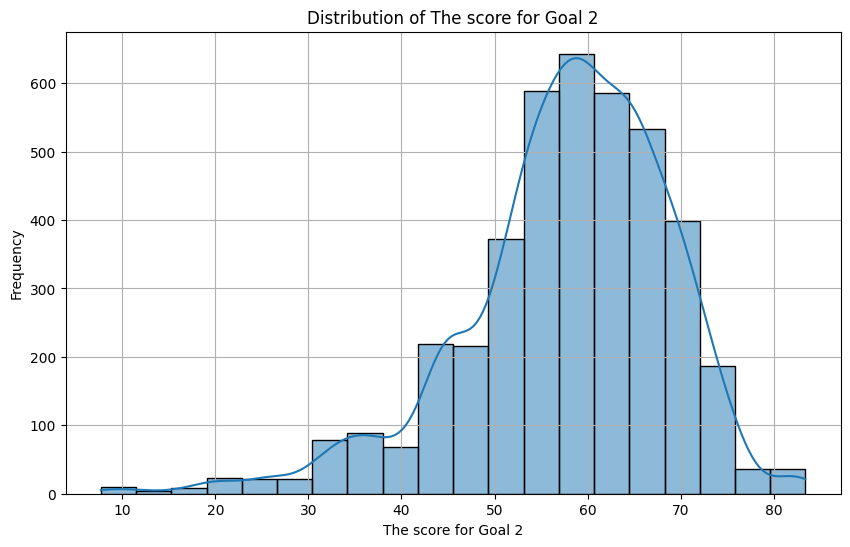

In [58]:
# Distribution of 'goal_2_score'
plt.figure(figsize=(10, 6))
sns.histplot(df['goal_2_score'], bins=20, kde=True)
plt.title('Distribution of The score for Goal 2')
plt.xlabel('The score for Goal 2')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


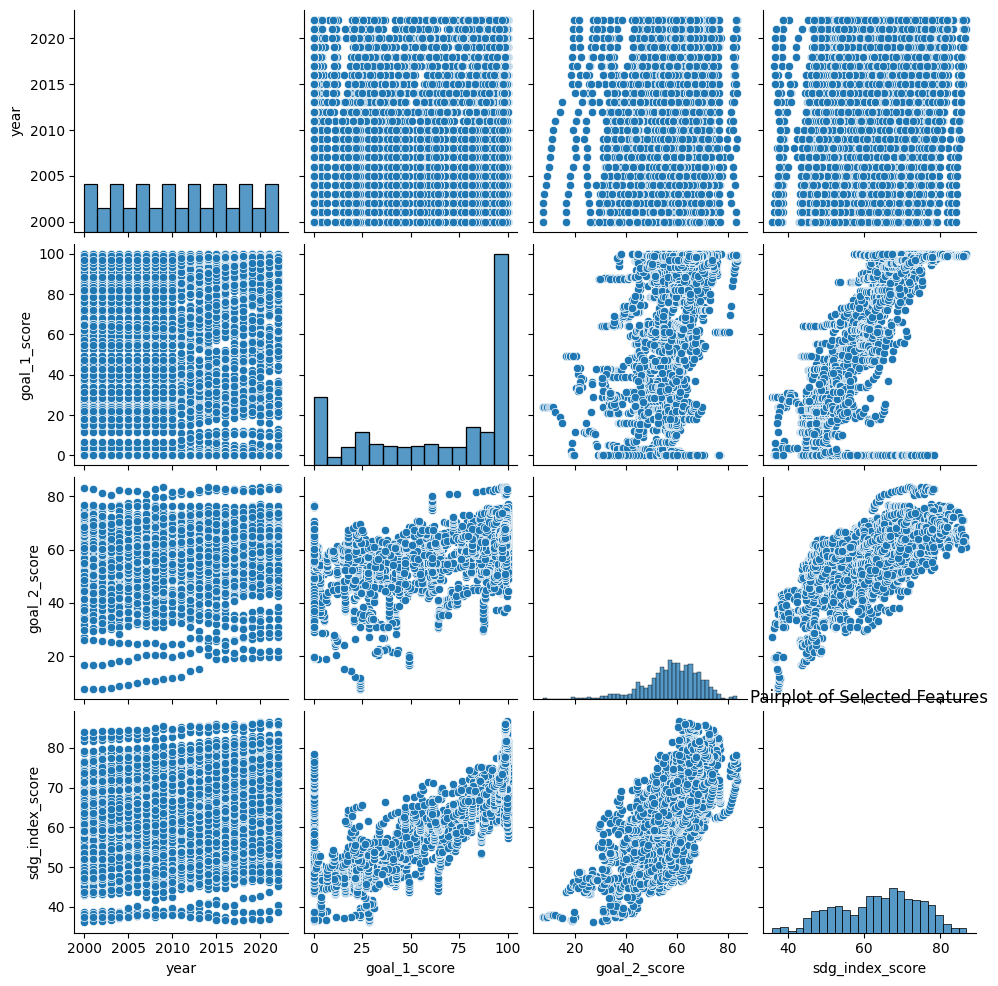

In [28]:
# Pairplot of selected features
sns.pairplot(df[['year', 'goal_1_score', 'goal_2_score', 'sdg_index_score']])
plt.title('Pairplot of Selected Features')
plt.show()


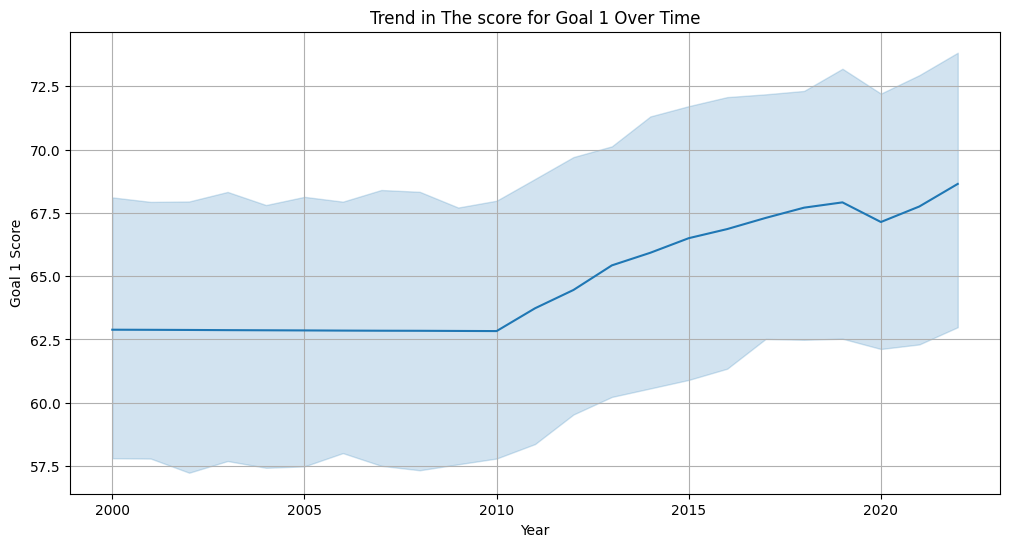

In [56]:
# Trends in 'goal_1_score' over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='goal_1_score', data=df)
plt.title('Trend in The score for Goal 1 Over Time')
plt.xlabel('Year')
plt.ylabel('Goal 1 Score')
plt.grid(True)
plt.show()


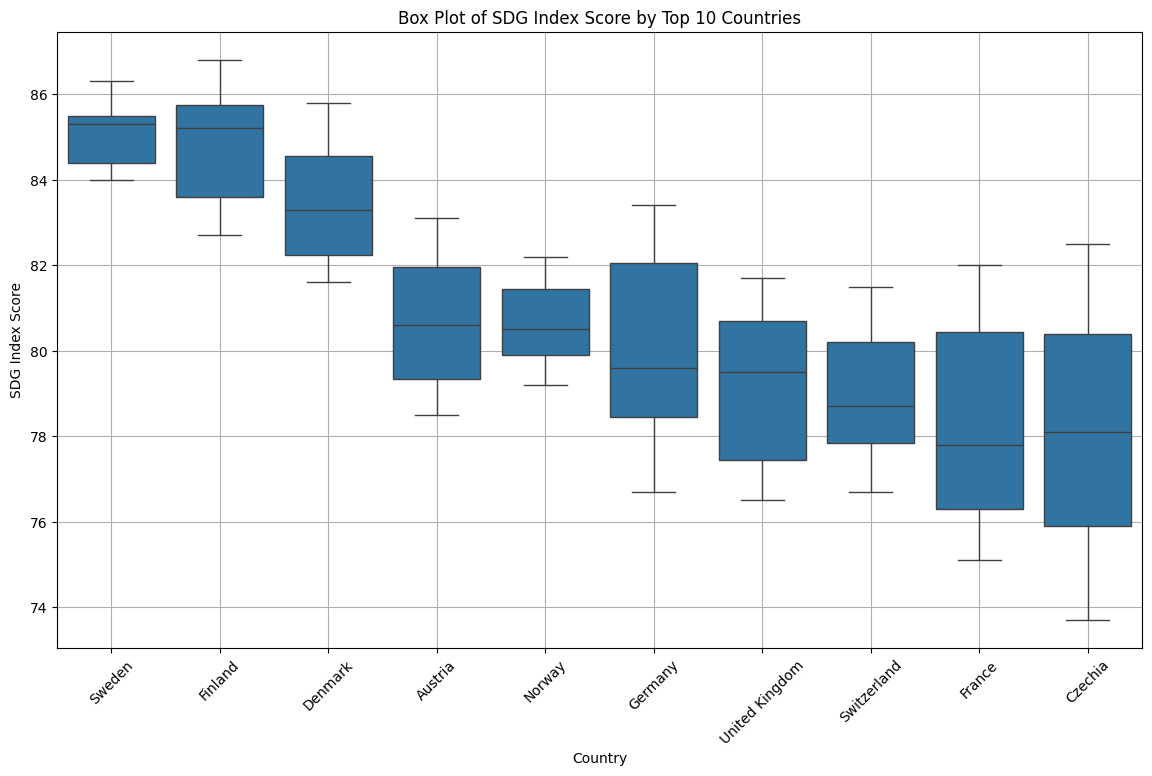

In [35]:
# finding top 10 countries by SDG Index score
top_countries = df.groupby('country')['sdg_index_score'].mean().sort_values(ascending=False).head(10).index

df_top_countries = df[df['country'].isin(top_countries)]

plt.figure(figsize=(14, 8))
sns.boxplot(x='country', y='sdg_index_score', data=df_top_countries, order=top_countries)
plt.title('Box Plot of SDG Index Score by Top 10 Countries')
plt.xlabel('Country')
plt.ylabel('SDG Index Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

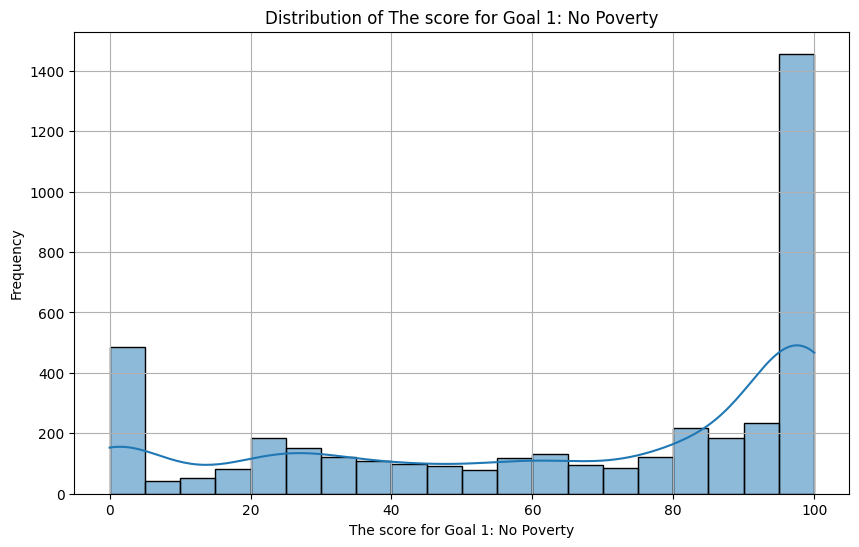

In [55]:
# Identify biases in 'goal_1_score'
plt.figure(figsize=(10, 6))
sns.histplot(df['goal_1_score'], bins=20, kde=True)
plt.title('Distribution of The score for Goal 1: No Poverty')
plt.xlabel('The score for Goal 1: No Poverty')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## correlation matrix using heatmap

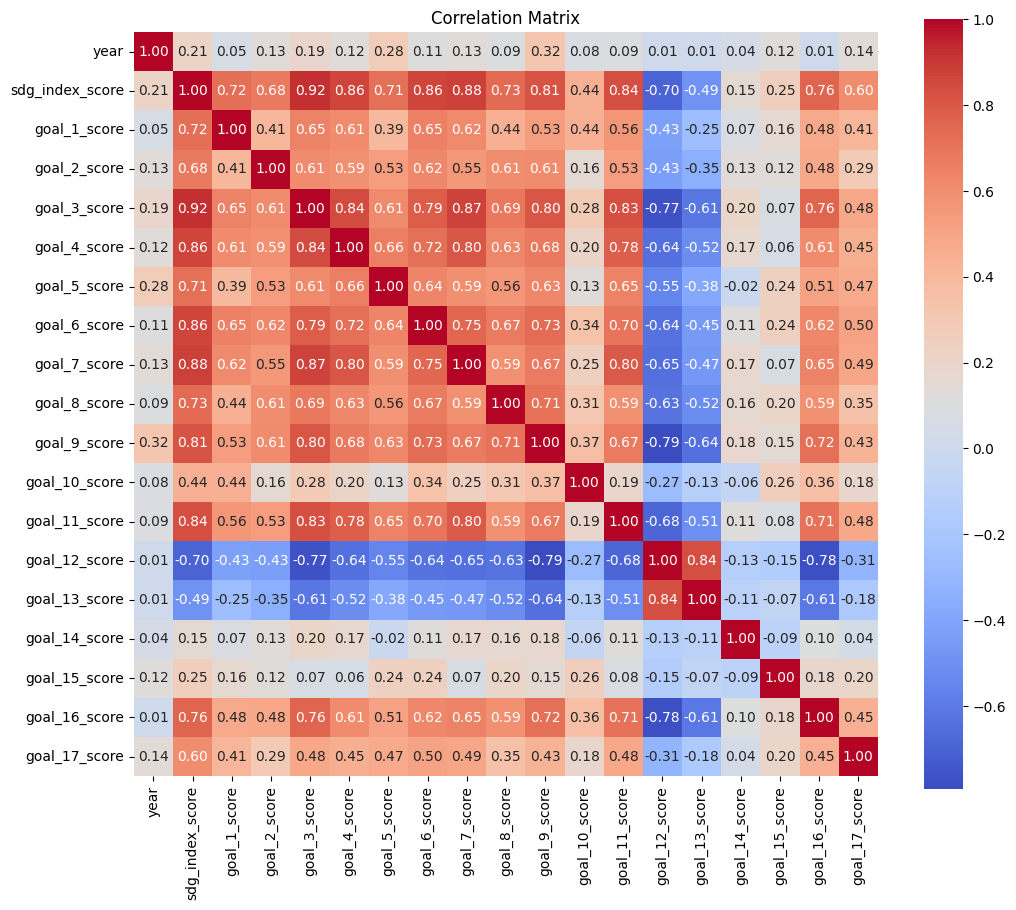

In [39]:
numeric_columns = df.select_dtypes(include=['number'])
correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix')
plt.show()


In [36]:
# Bias Identification and Mitigation

# Mitigate biases (hypothetical)
X = df[['goal_1_score', 'goal_2_score']]
y = df['sdg_index_score']

In [17]:
bins = [0, 50, 80, 100]
labels = ['Low', 'Medium', 'High']
y_categorical = pd.cut(y, bins=bins, labels=labels)

## Modelling

In [18]:
# Spliting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [45]:
# Data augmentation (Adding Gaussian noise)
noise = np.random.normal(0, 0.1, X_train.shape)
X_train_augmented = X_train + noise

In [46]:
# Re-sampling (Oversampling the minority classes)
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_train_augmented, y_train)

In [47]:
from sklearn.utils.class_weight import compute_class_weight
# Algorithmic adjustments (Using class weights)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_resampled), y=y_resampled)
class_weights_dict = dict(zip(np.unique(y_resampled), class_weights))

In [48]:
# Training RandomForestClassifier with class weights
model_rf_adjusted = RandomForestClassifier(random_state=42, class_weight=class_weights_dict)
model_rf_adjusted.fit(X_resampled, y_resampled)

RandomForestClassifier(class_weight={'High': 1.0, 'Low': 1.0, 'Medium': 1.0},
                       random_state=42)

In [49]:
# Prediction on the test set
y_pred_adjusted = model_rf_adjusted.predict(X_test)

# Evaluating model performance after mitigation
print("Accuracy after bias mitigation:", accuracy_score(y_test, y_pred_adjusted))
print("Classification Report after bias mitigation:")
print(classification_report(y_test, y_pred_adjusted))

Accuracy after bias mitigation: 0.8973429951690821
Classification Report after bias mitigation:
              precision    recall  f1-score   support

        High       0.40      0.44      0.42        41
         Low       0.83      0.84      0.84       108
      Medium       0.94      0.93      0.94       679

    accuracy                           0.90       828
   macro avg       0.73      0.74      0.73       828
weighted avg       0.90      0.90      0.90       828




Confusion Matrix after bias mitigation:
[[ 18   0  23]
 [  0  91  17]
 [ 27  18 634]]


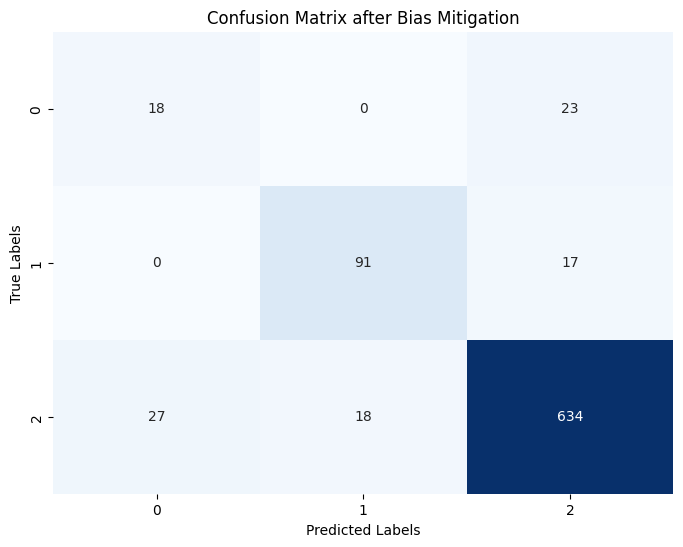

In [50]:
# Confusion matrix after mitigation
conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)
print('\nConfusion Matrix after bias mitigation:')
print(conf_matrix_adjusted)

# confusion matrix after mitigation
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_adjusted, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix after Bias Mitigation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## Comparative Analysis

In [51]:
# Model performance before bias mitigation
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

In [52]:
# Evaluating model performance before mitigation
print("Accuracy before bias mitigation:", accuracy_score(y_test, y_pred))
print("Classification Report before bias mitigation:")
print(classification_report(y_test, y_pred))

Accuracy before bias mitigation: 0.9202898550724637
Classification Report before bias mitigation:
              precision    recall  f1-score   support

        High       0.57      0.56      0.57        41
         Low       0.90      0.81      0.85       108
      Medium       0.94      0.96      0.95       679

    accuracy                           0.92       828
   macro avg       0.81      0.78      0.79       828
weighted avg       0.92      0.92      0.92       828




Confusion Matrix before bias mitigation:
[[ 23   0  18]
 [  0  87  21]
 [ 17  10 652]]


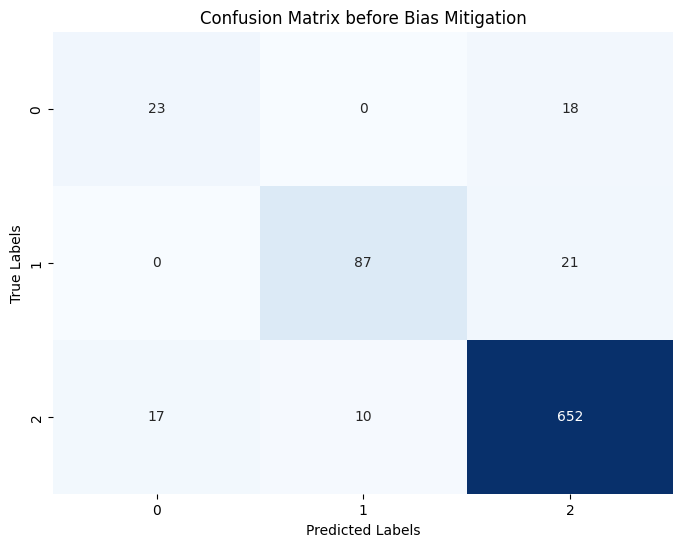

In [53]:
# Confusion matrix before mitigation
conf_matrix_before = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix before bias mitigation:')
print(conf_matrix_before)

# confusion matrix before mitigation
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_before, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix before Bias Mitigation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()